# Makemore part 3 non-Pytorch

Use the old implementation and add Kaiming Initialization and BatchNorm

# Running Notes:

- Imp to make the weights of the last layer as low as possible
- Imp to do Kaiming initialization
- If Kaiming gain is very small, the hidden actvations can get uniform or even normal since tanh won't make a difference
- If Kaiming gain is very large, we acheiev similar results as before
- **Best results**:
    - Default: Train: 2.078, Val: 2.131
    - Only make last weights small: Train: 1.986, Val: 2.102 
    - With correct Kaiming init: Train: 1.961, Val: 2.087

In [2]:
from sklearn.model_selection import train_test_split
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

## Step 1: Create the dataset for train, val, test

In [3]:
with open("names.txt", "r") as file:
    names = file.read().splitlines()

len(names)

32033

In [5]:
chars = sorted(list(set("".join(name for name in names))))
chars

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [6]:
stoi, itos = {}, {}

stoi['.'] = 0
itos[0] = '.'

for i, char in enumerate(chars):
    stoi[char] = i + 1
    itos[i + 1] = char

len(stoi), len(itos)

(27, 27)

In [19]:
def split_names_dataset(names, random_state=42):
    names_train, names_temp = train_test_split(
        names,
        test_size=0.2,
        random_state=random_state,
        shuffle=True
    )

    # Second split: Split the remaining 20% into two equal parts (10% each)
    names_dev, names_test = train_test_split(
        names_temp,
        test_size=0.5,
        random_state=random_state,
        shuffle=True
    )

    return names_train, names_dev, names_test

names_train, names_dev, names_test = split_names_dataset(names)
len(names_train), len(names_dev), len(names_test)

(25626, 3203, 3204)

In [44]:
def create_dataset(names, block_size=3):
    X, y = [], []

    for name in names:
        name = (['.'] * block_size) + list(name) + ['.']

        for i, ch in enumerate(name[block_size:]):
            # print(f"{name[i:i + block_size]} ---> {ch}")
            X.append([stoi[c] for c in name[i:i + block_size]])
            y.append(stoi[ch])
            

    X = torch.Tensor(X).long()
    y = torch.Tensor(y).long()

    return X, y


In [45]:
X_train, y_train = create_dataset(names_train)
X_dev, y_dev = create_dataset(names_dev)
X_test, y_test = create_dataset(names_test)

In [46]:
X_train.shape, y_train.shape

(torch.Size([182497, 3]), torch.Size([182497]))

In [47]:
X_dev.shape, y_dev.shape

(torch.Size([22882, 3]), torch.Size([22882]))

In [48]:
X_test.shape, y_test.shape


(torch.Size([22767, 3]), torch.Size([22767]))

## Step 2: Create the model

In [56]:
def create_model(vocab_size, block_size, emb_dim, hidden_dim, direct=False):
    g = torch.Generator().manual_seed(2147483647)

    # create embeddimg matrix
    C = torch.randn((vocab_size, emb_dim), dtype=torch.float32, generator=g)

    # create the hidden layer params: weights and bias:
    W1 = torch.randn((emb_dim * block_size, hidden_dim), dtype=torch.float32, generator=g)
    b1 = torch.randn((hidden_dim,), dtype=torch.float32, generator=g)

    # create the output layer params: weights and bias:
    W2 = torch.randn((hidden_dim, vocab_size), dtype=torch.float32, generator=g)
    b2 = torch.randn((vocab_size,), dtype=torch.float32, generator=g)

    params = [C, W1, b1, W2, b2]

    if direct:
        Wdirect = torch.randn((emb_dim * block_size, vocab_size), dtype=torch.float32, generator=g)
        params.append(Wdirect)

    return params

In [57]:
params_best = create_model(emb_dim=10, hidden_dim=400, block_size=3,\
                                 vocab_size=len(stoi), direct=True)

In [58]:
for p in params_best:
    p.requires_grad = True

## Step 3: Create the forward pass, and the training loop

In [59]:
def forward(batch_x, params, direct=False):
    if direct:
        C, W1, b1, W2, b2, Wdirect = params
    else:
        C, W1, b1, W2, b2 = params

    inp = C[batch_x].view(batch_x.shape[0], -1)
    hidden = inp @ W1 + b1
    hidden = torch.tanh(hidden)

    logits = hidden @ W2 + b2

    if direct:
        logits += inp @ Wdirect

    return logits

In [84]:
def train(X, y, params, num_steps, batch_size, lr_scheduler, direct=False):
    g = torch.Generator().manual_seed(2147483647)

    stepi, lossi = [], []

    for step in range(num_steps):
        # Make params grad None
        for p in params:
            p.grad = None

        # Create the batch
        batch = torch.randint(0, len(X), size=(batch_size,), generator=g).long()
        batch_x, batch_y = X[batch], y[batch]

        # Do a forward pass
        batch_logits = forward(batch_x, params, direct)

        # Compute loss
        loss = F.cross_entropy(batch_logits, batch_y)

        # backward
        loss.backward()

        # Update params:
        lr = lr_scheduler(step)
        with torch.no_grad():
            for p in params:
                p.data -= lr * p.grad

        stepi.append(step)
        lossi.append(loss.log10().item())

        if step % 10000 == 0:
            print(f"Step {step} --> {loss.item()}")


    return stepi, lossi

In [61]:
stepi, lossi = train(X_train, y_train, params_best, num_steps=200000,\
                      batch_size=128,\
                          lr_scheduler=lambda i: (10**(-0.95)) if i < 100000 else (10**(-1.95)),\
                            direct=True)

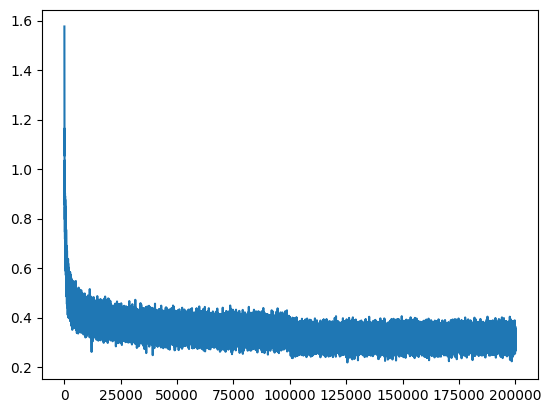

In [62]:
plt.plot(stepi, lossi)

## Step 4: Compute losses

In [63]:
@torch.no_grad()
def compute_loss(X, y, params, direct=False):
    logits = forward(X, params, direct)
    loss = F.cross_entropy(logits, y)
    return loss.item()

In [65]:
train_loss = compute_loss(X_train, y_train, params_best, direct=True)
dev_loss = compute_loss(X_dev, y_dev, params_best, direct=True)
train_loss, dev_loss

(2.0785534381866455, 2.131584644317627)

## Step 5: Solve the first large loss problem by last weight scaling and kaimning int

In [70]:
params_best = create_model(emb_dim=10, hidden_dim=400, block_size=3,\
                                 vocab_size=len(stoi), direct=True)
for p in params_best:
    p.requires_grad = True

stepi, lossi = train(X_train, y_train, params_best, num_steps=1,\
                      batch_size=128,\
                          lr_scheduler=lambda i: (10**(-0.95)) if i < 100000 else (10**(-1.95)),\
                            direct=True)

Step 0 --> 37.66815948486328


In [71]:
logits = forward(X_train, params_best, direct=True)
logits[0]

tensor([-16.4366,   6.3737,  -0.2251,  11.2440,  -2.3325,  12.2346,  21.3338,
          0.3986, -17.1878,   8.3857, -10.9140,  -9.2111,  10.2799,  -7.2514,
         -1.4671,  -3.2068,   2.4105,  19.8522,  17.9052, -15.6274,  19.8848,
        -20.1469,  22.7773,  -6.6668,  -2.9250,  -2.9757,  -7.8804],
       grad_fn=<SelectBackward0>)

### Method 1: Try to bring the final logits lower

Do this by scaling W2 and b2 to small values

In [ ]:
params_best = create_model(emb_dim=10, hidden_dim=400, block_size=3,\
                                 vocab_size=len(stoi), direct=False)

params_best[-3] *= 0.01
params_best[-2] *= 0.00

for p in params_best:
    p.requires_grad = True

In [80]:
tepi, lossi = train(X_train, y_train, params_best, num_steps=1,\
                      batch_size=128,\
                          lr_scheduler=lambda i: (10**(-0.95)) if i < 100000 else (10**(-1.95)),\
                            direct=False)

Step 0 --> 3.986743450164795


In [81]:
logits = forward(X_train, params_best, direct=False)
logits[0]

tensor([-0.8445,  1.2808,  0.6544,  0.2816, -0.6650, -0.1614, -1.0916,  0.5883,
        -1.0213, -0.4217,  1.2437,  1.1314,  0.5232,  0.3530,  0.5274, -2.7495,
         0.8066, -0.1144, -0.7368, -0.7153, -0.2074, -1.0885,  0.4088, -0.2760,
         0.2700, -0.7908, -0.4368], grad_fn=<SelectBackward0>)

Full computation

In [110]:
params_best_last_small = create_model(emb_dim=10, hidden_dim=400, block_size=3,\
                                 vocab_size=len(stoi), direct=False)

params_best_last_small[-2] *= 0.01
params_best_last_small[-1] *= 0.00

for p in params_best_last_small:
    p.requires_grad = True

In [111]:
stepi, lossi = train(X_train, y_train, params_best_last_small, num_steps=200000,\
                      batch_size=128,\
                          lr_scheduler=lambda i: (10**(-0.95)) if i < 100000 else (10**(-1.95)),\
                            direct=False)

Step 0 --> 3.3076834678649902
Step 10000 --> 2.1443631649017334
Step 20000 --> 2.011775016784668
Step 30000 --> 1.9220138788223267
Step 40000 --> 2.2540204524993896
Step 50000 --> 2.353724479675293
Step 60000 --> 2.1943118572235107
Step 70000 --> 2.163327693939209
Step 80000 --> 1.9016458988189697
Step 90000 --> 1.9318335056304932
Step 100000 --> 2.0417988300323486
Step 110000 --> 2.06207013130188
Step 120000 --> 1.9415873289108276
Step 130000 --> 2.177067518234253
Step 140000 --> 2.055155038833618
Step 150000 --> 2.0092415809631348
Step 160000 --> 1.9215338230133057
Step 170000 --> 1.6230871677398682
Step 180000 --> 1.956576943397522
Step 190000 --> 1.9722552299499512


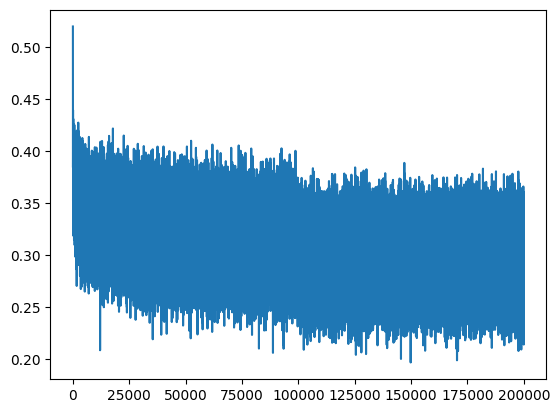

In [112]:
plt.plot(stepi, lossi)

In [113]:
train_loss = compute_loss(X_train, y_train, params_best_last_small, direct=False)
dev_loss = compute_loss(X_dev, y_dev, params_best_last_small, direct=False)
train_loss, dev_loss

(1.9865891933441162, 2.1021218299865723)

But still this network has the problem of hidden layers being too skewed to -1 and 1. This leads to no laerning in majority cases since the fradient of tanh follows `(1-o ** 2)` which is not good for learning

In [114]:
params_best_last_small2 = create_model(emb_dim=10, hidden_dim=400, block_size=3,\
                                 vocab_size=len(stoi), direct=False)

params_best_last_small2[-2] *= 0.01
params_best_last_small2[-1] *= 0.00

In [115]:
batch = torch.randint(0, len(X_train), size=(32,)).long()
batch_x, batch_y = X_train[batch], y_train[batch]

C, W1, b1, W2, b2 = params_best_last_small2

inp = C[batch_x].view(batch_x.shape[0], -1)
hidden = inp @ W1 + b1
hidden_tanh = torch.tanh(hidden)

hidden_tanh.shape

torch.Size([32, 400])

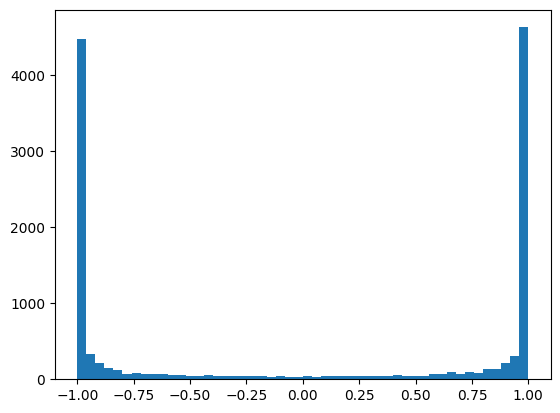

In [116]:
plt.hist(hidden_tanh.view(-1).tolist(), bins=50);

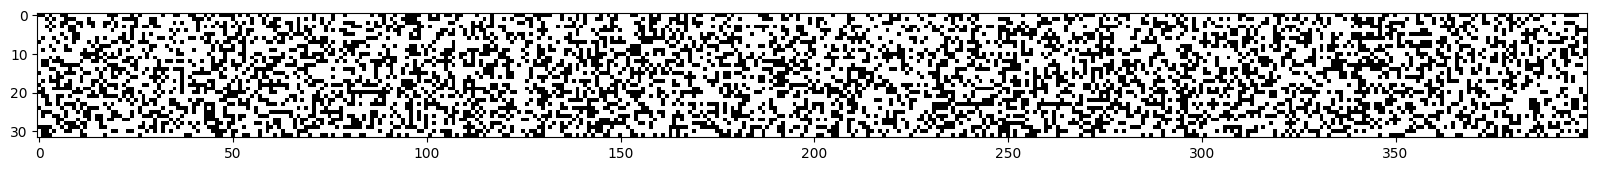

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(hidden_tanh.abs() > 0.99, cmap='gray', interpolation='nearest') # do not want lot of whites

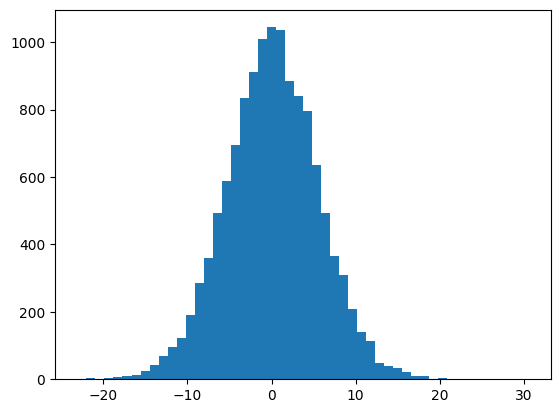

In [117]:
plt.hist(hidden.view(-1).tolist(), bins=50);

### Method 2: Use Kaiming init of the hidden weight parameters

In [136]:
def create_model_kaiming_init(vocab_size, block_size, emb_dim, hidden_dim, direct=False):
    g = torch.Generator().manual_seed(2147483647)

    # create embeddimg matrix
    C = torch.randn((vocab_size, emb_dim), dtype=torch.float32, generator=g)

    # create the hidden layer params: weights and bias, use Kaiming init on them:
    W1 = torch.randn((emb_dim * block_size, hidden_dim), dtype=torch.float32, generator=g) * 5/3 * (1 / ((emb_dim * block_size) ** (0.5)))
    b1 = torch.randn((hidden_dim,), dtype=torch.float32, generator=g) * 0.00

    # create the output layer params: weights and bias, use a bit of noisy weight and 0 biases:
    W2 = torch.randn((hidden_dim, vocab_size), dtype=torch.float32, generator=g) * 0.01
    b2 = torch.randn((vocab_size,), dtype=torch.float32, generator=g) * 0.00

    params = [C, W1, b1, W2, b2]

    if direct:
        Wdirect = torch.randn((emb_dim * block_size, vocab_size), dtype=torch.float32, generator=g)
        params.append(Wdirect)

    return params

In [137]:
params_kaiming_init = create_model_kaiming_init(emb_dim=10, hidden_dim=400, block_size=3,\
                                 vocab_size=len(stoi), direct=False)

for p in params_kaiming_init:
    p.requires_grad = True

In [138]:
with torch.no_grad():
    batch = torch.randint(0, len(X_train), size=(32,)).long()
    batch_x, batch_y = X_train[batch], y_train[batch]

    C, W1, b1, W2, b2 = params_kaiming_init

    inp = C[batch_x].view(batch_x.shape[0], -1)
    hidden = inp @ W1 + b1
    hidden_tanh = torch.tanh(hidden)

hidden_tanh.shape

torch.Size([32, 400])

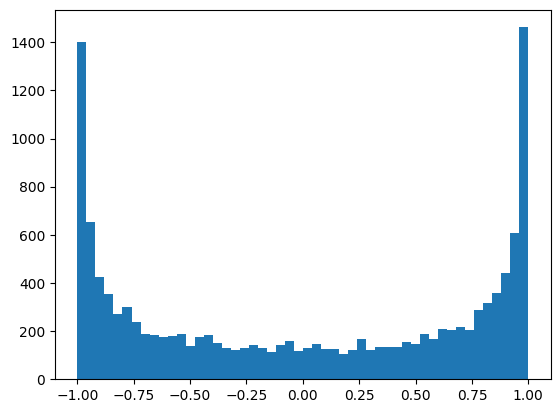

In [139]:
plt.hist(hidden_tanh.view(-1).tolist(), bins=50);

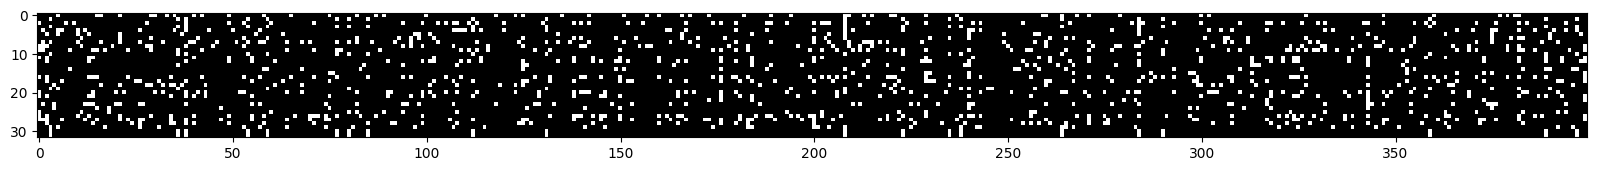

In [140]:
plt.figure(figsize=(20,10))
plt.imshow(hidden_tanh.abs() > 0.99, cmap='gray', interpolation='nearest') # do not want lot of whites

In [141]:
stepi, lossi = train(X_train, y_train, params_kaiming_init, num_steps=200000,\
                      batch_size=128,\
                          lr_scheduler=lambda i: (10**(-0.95)) if i < 100000 else (10**(-1.95)),\
                            direct=False)

Step 0 --> 3.3024985790252686
Step 10000 --> 2.0995545387268066
Step 20000 --> 1.968756079673767
Step 30000 --> 1.8890882730484009
Step 40000 --> 2.202319622039795
Step 50000 --> 2.262089252471924
Step 60000 --> 2.2036705017089844
Step 70000 --> 2.139057159423828
Step 80000 --> 1.8762964010238647
Step 90000 --> 1.9492497444152832
Step 100000 --> 1.9298170804977417
Step 110000 --> 2.0279290676116943
Step 120000 --> 1.908929467201233
Step 130000 --> 2.2067532539367676
Step 140000 --> 2.023083448410034
Step 150000 --> 2.0071048736572266
Step 160000 --> 1.8962761163711548
Step 170000 --> 1.621548056602478
Step 180000 --> 1.8972588777542114
Step 190000 --> 1.9207940101623535


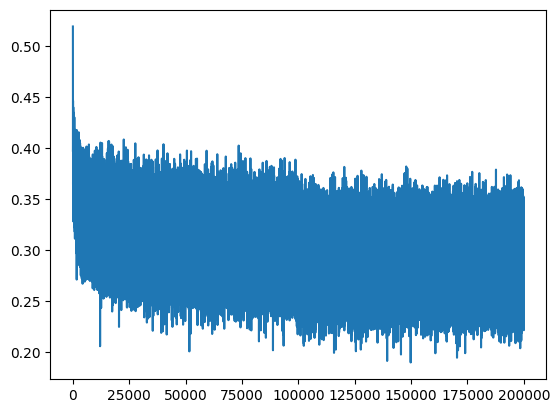

In [142]:
plt.plot(stepi, lossi)

In [144]:
train_loss = compute_loss(X_train, y_train, params_kaiming_init, direct=False)
dev_loss = compute_loss(X_dev, y_dev, params_kaiming_init, direct=False)
train_loss, dev_loss

(1.9607925415039062, 2.0871522426605225)

### Analyse more Kaiming init gain values

In [145]:
def create_model_kaiming_init(vocab_size, block_size, emb_dim, hidden_dim, kaiming_gain, direct=False):
    g = torch.Generator().manual_seed(2147483647)

    # create embeddimg matrix
    C = torch.randn((vocab_size, emb_dim), dtype=torch.float32, generator=g)

    # create the hidden layer params: weights and bias, use Kaiming init on them:
    W1 = torch.randn((emb_dim * block_size, hidden_dim), dtype=torch.float32, generator=g) * kaiming_gain * (1 / ((emb_dim * block_size) ** (0.5)))
    b1 = torch.randn((hidden_dim,), dtype=torch.float32, generator=g) * 0.00

    # create the output layer params: weights and bias, use a bit of noisy weight and 0 biases:
    W2 = torch.randn((hidden_dim, vocab_size), dtype=torch.float32, generator=g) * 0.01
    b2 = torch.randn((vocab_size,), dtype=torch.float32, generator=g) * 0.00

    params = [C, W1, b1, W2, b2]

    if direct:
        Wdirect = torch.randn((emb_dim * block_size, vocab_size), dtype=torch.float32, generator=g)
        params.append(Wdirect)

    return params

#### Gain is small

We expect he hidden layer to be very uniform

In [155]:
params_kaiming_init_gain_small = create_model_kaiming_init(emb_dim=10, hidden_dim=400, block_size=3,\
                                 vocab_size=len(stoi), kaiming_gain=0.1, direct=False)

for p in params_kaiming_init_gain_small:
    p.requires_grad = True

In [156]:
with torch.no_grad():
    batch = torch.randint(0, len(X_train), size=(32,)).long()
    batch_x, batch_y = X_train[batch], y_train[batch]

    C, W1, b1, W2, b2 = params_kaiming_init_gain_small

    inp = C[batch_x].view(batch_x.shape[0], -1)
    hidden = inp @ W1 + b1
    hidden_tanh = torch.tanh(hidden)

hidden_tanh.shape

torch.Size([32, 400])

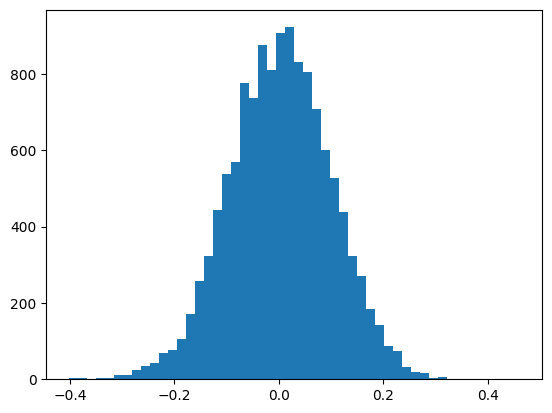

In [ ]:
plt.hist(hidden_tanh.view(-1).tolist(), bins=50); #actually retains normal lol

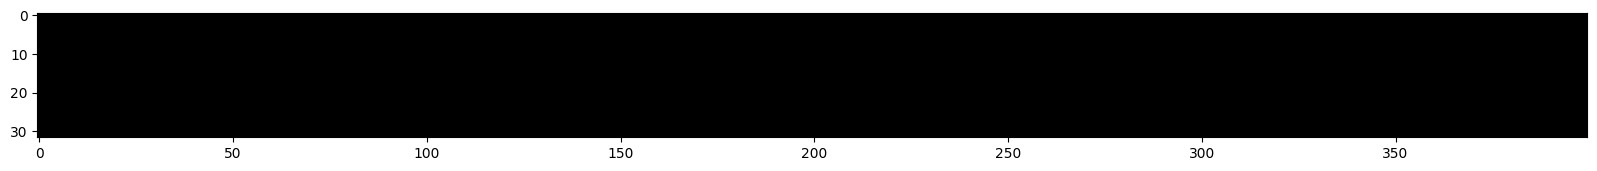

In [158]:
plt.figure(figsize=(20,10))
plt.imshow(hidden_tanh.abs() > 0.99, cmap='gray', interpolation='nearest') # do not want lot of whites

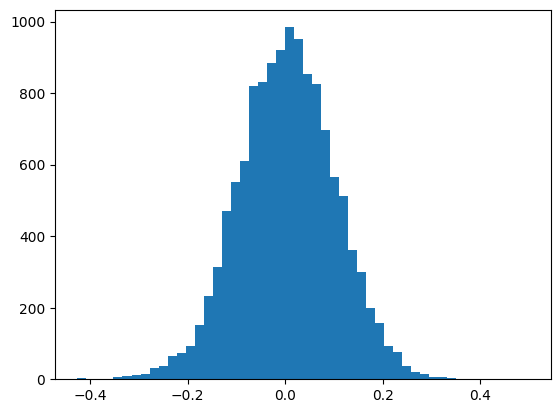

In [163]:
plt.hist(hidden.view(-1).tolist(), bins=50);


In [159]:
stepi, lossi = train(X_train, y_train, params_kaiming_init_gain_small, num_steps=200000,\
                      batch_size=128,\
                          lr_scheduler=lambda i: (10**(-0.95)) if i < 100000 else (10**(-1.95)),\
                            direct=False)

Step 0 --> 3.2949187755584717
Step 10000 --> 2.232130289077759
Step 20000 --> 2.0863866806030273
Step 30000 --> 2.0103566646575928
Step 40000 --> 2.2455039024353027
Step 50000 --> 2.259533166885376
Step 60000 --> 2.2449889183044434
Step 70000 --> 2.1093666553497314
Step 80000 --> 1.885899305343628
Step 90000 --> 1.9673547744750977
Step 100000 --> 1.9777061939239502
Step 110000 --> 2.073580265045166
Step 120000 --> 2.004122495651245
Step 130000 --> 2.2432491779327393
Step 140000 --> 2.076470136642456
Step 150000 --> 1.9954599142074585
Step 160000 --> 1.9082549810409546
Step 170000 --> 1.6837975978851318
Step 180000 --> 2.0409998893737793
Step 190000 --> 1.9626542329788208


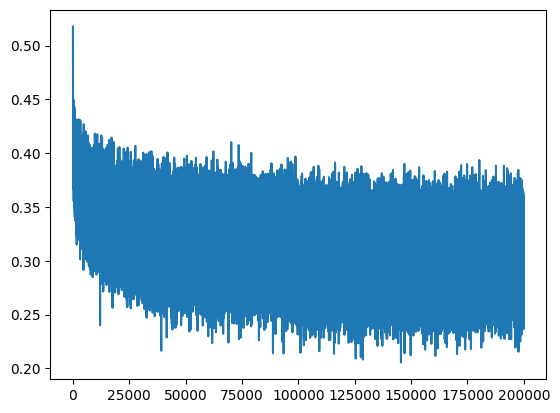

In [160]:
plt.plot(stepi, lossi)

In [162]:
train_loss = compute_loss(X_train, y_train, params_kaiming_init_gain_small, direct=False)
dev_loss = compute_loss(X_dev, y_dev, params_kaiming_init_gain_small, direct=False)
train_loss, dev_loss

(2.0214827060699463, 2.096877098083496)

#### Gain is large

We expect he same dist as before

In [164]:
params_kaiming_init_gain_large = create_model_kaiming_init(emb_dim=10, hidden_dim=400, block_size=3,\
                                 vocab_size=len(stoi), kaiming_gain=5.0, direct=False)

for p in params_kaiming_init_gain_large:
    p.requires_grad = True

In [165]:
with torch.no_grad():
    batch = torch.randint(0, len(X_train), size=(32,)).long()
    batch_x, batch_y = X_train[batch], y_train[batch]

    C, W1, b1, W2, b2 = params_kaiming_init_gain_large

    inp = C[batch_x].view(batch_x.shape[0], -1)
    hidden = inp @ W1 + b1
    hidden_tanh = torch.tanh(hidden)

hidden_tanh.shape

torch.Size([32, 400])

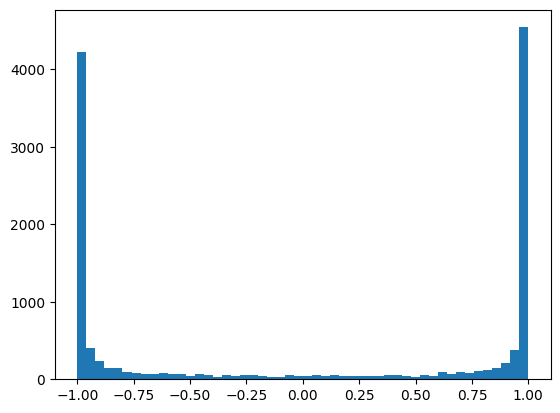

In [166]:
plt.hist(hidden_tanh.view(-1).tolist(), bins=50); #actually retains normal lol

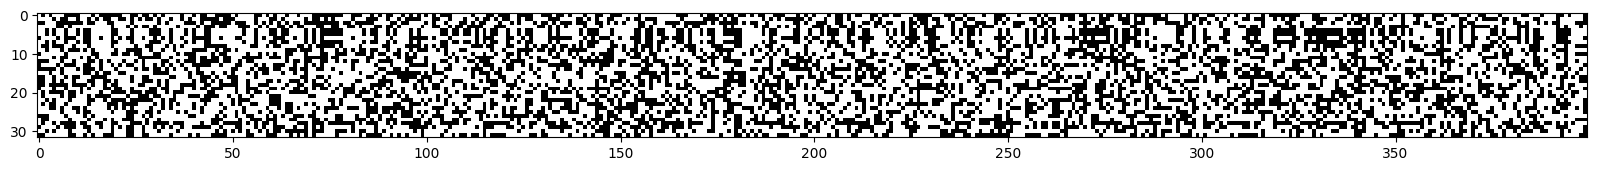

In [167]:
plt.figure(figsize=(20,10))
plt.imshow(hidden_tanh.abs() > 0.99, cmap='gray', interpolation='nearest') # do not want lot of whites

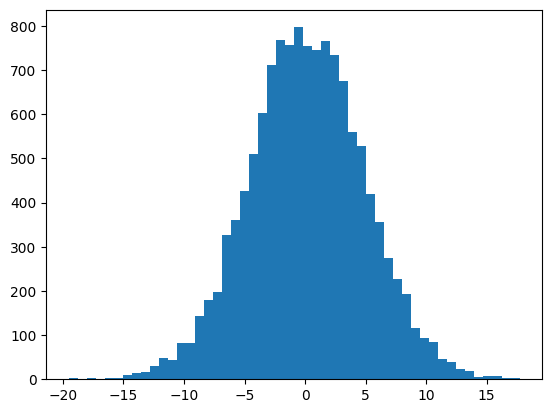

In [168]:
plt.hist(hidden.view(-1).tolist(), bins=50);


In [169]:
stepi, lossi = train(X_train, y_train, params_kaiming_init_gain_large, num_steps=200000,\
                      batch_size=128,\
                          lr_scheduler=lambda i: (10**(-0.95)) if i < 100000 else (10**(-1.95)),\
                            direct=False)

Step 0 --> 3.305187463760376
Step 10000 --> 2.129697322845459
Step 20000 --> 2.0091700553894043
Step 30000 --> 1.9366008043289185
Step 40000 --> 2.2473063468933105
Step 50000 --> 2.287635564804077
Step 60000 --> 2.308945894241333
Step 70000 --> 2.175124168395996
Step 80000 --> 1.912618637084961
Step 90000 --> 1.9608737230300903
Step 100000 --> 1.9753092527389526
Step 110000 --> 2.0313918590545654
Step 120000 --> 1.9370874166488647
Step 130000 --> 2.181528329849243
Step 140000 --> 2.0509145259857178
Step 150000 --> 2.020589590072632
Step 160000 --> 1.9032037258148193
Step 170000 --> 1.6584070920944214
Step 180000 --> 1.9605176448822021
Step 190000 --> 1.9655297994613647


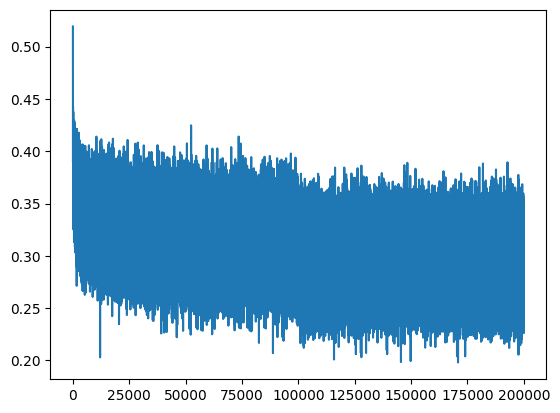

In [170]:
plt.plot(stepi, lossi)

In [171]:
train_loss = compute_loss(X_train, y_train, params_kaiming_init_gain_large, direct=False)
dev_loss = compute_loss(X_dev, y_dev, params_kaiming_init_gain_large, direct=False)
train_loss, dev_loss

(1.983311414718628, 2.0980238914489746)

## Step 6: Add BatchNorm